<h3 id='nav'>Train,Predict&Validate. 4 выборки: miresol200-d,  val (без общих цепей), d, val2 </h3>

<ol>
<li><a href='#1'> Тренируемся на minresol (цепочки длины < 200).</a></li>
<li><a href='#2'> Предсказываем на оставшихся трех выборках, scores.</a></li>
<li><a href='#3'> Графики распределений.</a></li>
</ol>

<a href="https://pollytikhonova.github.io/coursework/validation/"><img src="https://pollytikhonova.github.io/coursework/GitHub-Mark-32px.png" alt="В репозиторий" title="В репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a> <a href="Train,Predict&Validate. 4 sets -  miresol-d,  val, d, val2. v3.0. Chains less 200.ipynb" download target="_blank">Скачать этот ipynb-файл можно здесь</a>

In [3]:
import sys
sys.path.insert(0, '../basic codes')

import class_magnesium_not_drop_na
from class_magnesium_not_drop_na import *

from matplotlib.backends.backend_pdf import PdfPages

import sys
from IPython.core.display import clear_output
def change_output(x):
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()

from IPython.core.display import display, HTML

In [2]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

In [3]:
class Magnesium_validation(Magnesium):    
    def __init__(self, validation_file, drop_common = True,  *args, **kwargs):
        change_output('Loading data...')
        super(Magnesium_validation, self).__init__(*args, **kwargs)
        change_output('Loading validation data...')
        self.validation_data = pd.read_table(validation_file).fillna(method = 'backfill', axis = 0)
        if np.sum(self.validation_data.isnull().any(axis=1)) > 0:
            self.validation_data.fillna(method = 'pad', axis = 0, inplace = True)
        self.validation_data = self.validation_data[~(self.validation_data['chainlen']>1000)]
        angles = ['p', 'phase-angle', 'e-z',
                  'tm', 'sszp', 'etap', 'etapp', 
                  'splay', 'thetap', 'thetapp']
        angles = np.ravel([[''.join([i,j]) for i in angles] for j in ['m2', 'm1', '', '1', '2']])
        self.validation_data.drop(angles, axis=1)
        self.data.drop(angles, axis=1)
        if ('DSSR' in self.data.columns):
            self.data.drop('DSSR', axis=1, inplace=True)
        if ('DSSR' in self.validation_data.columns):
            self.validation_data.drop('DSSR', axis=1, inplace=True)
        change_output('Data loaded')
        change_output('Data processing')        
        self.x_test = np.matrix(self.validation_data[list(self.validation_data.columns)[1:-1]])
        self.y_test = np.array(self.validation_data[list(self.validation_data.columns)[-1]])
        self.data_numpy = np.matrix(self.data)
        self.x = self.data_numpy[:, 1:-1]
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])
        change_output("Data processed")
        
    def train(self, n_splits):
        change_output("Start training...")
        self.trained_model_validation = self.model
        x = self.x
        y = self.y
        sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = 'auto', random_state=42)
        
        splitted = sss.split(x, y) 
        iterator = tqdm_notebook(splitted, desc = "Splits", leave = True) if tqdm else splitted            
        for train_index, test_index in iterator:               
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            x_test, y_test = x[test_index], y[test_index]
            self.trained_model_validation.fit(x_train, y_train)
            self.train_score.append(self.trained_model_validation.score(x_train, y_train))
            self.test_score.append(self.trained_model_validation.score(x_test, y_test))
        if not os.path.isdir('trained_models'):
            os.mkdir('trained_models')
        model_name = '%s_depth=%d_leaves=%d_%s_validation'%(re.split("\.|\'", str(self.trained_model_validation.__class__))[-2],
                                              self.trained_model_validation.__dict__['max_depth'], 
                                              self.trained_model_validation.__dict__['min_samples_leaf'],
                                              self.filename)
        with open("trained_models/"+model_name+".sav", 'wb') as file_to_save:
            pickle.dump(self.trained_model_validation, file_to_save)
        change_output("Trained")
        return [x[test_index], y[test_index]]
            
            
    def compute_validated(self, n_splits = 3):
        x_test, y_test = self.train(n_splits)
        data = self.predict(x = self.x_test, y = self.y_test, model=self.trained_model_validation)
        self.show_plots(data['plots'])  
        plt.text(0.02, 0.5, 'Predict', fontsize=14)
        data_train = self.predict(x = x_test, y = y_test, model=self.trained_model_validation)
        self.show_plots(data_train['plots'])  
        plt.text(0.02, 0.5, 'Train', fontsize=14)
        self.validation_data['prediction'] = data['prediction']
        self.validation_data['probability'] = data['probability']
        return data       
    
def load_data(filename):
    data = pd.read_table(filename).fillna(method = 'backfill', axis = 0)
    if np.sum(data.isnull().any(axis=1)) > 0:
        data.fillna(method = 'pad', axis = 0, inplace = True)
    data = data[~(data['chainlen']>1000)]
    angles = ['p', 'phase-angle', 'e-z',
              'tm', 'sszp', 'etap', 'etapp', 
              'splay', 'thetap', 'thetapp']
    angles = np.ravel([[''.join([i,j]) for i in angles] for j in ['m2', 'm1', '', '1', '2']])
    data.drop(angles, axis=1)
    if ('DSSR' in data.columns):
        data.drop('DSSR', axis=1, inplace=True)  
    x_test = np.matrix(data[list(data.columns)[1:-1]])
    y_test = np.array(data[list(data.columns)[-1]])
    change_output('Data loaded')
    return {'data':data, 'x':x_test, 'y':y_test}

<h3 id='1'> Тренируемся на minresol <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

In [4]:
#fold = 'https://tikhonovapolly.files.wordpress.com/2017/09/'
fold = '../main_datasets/validation/'
m_val = Magnesium_validation(fold+'set_d_A_7.csv', drop_common = True, file_ = "set_minresol200-minus-d_A_7.csv", fold = fold,
     model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth = 39, min_samples_leaf = 1))

Data processed

In [5]:
x_test, y_test = m_val.train(n_splits=5);

Trained

In [6]:
print('Train score: mean / std - %.3f / %.3f' %
      (np.array(m_val.train_score).mean(),np.array(m_val.train_score).std()))
print('Test score: mean / std - %.3f / %.3f' % 
      (np.array(m_val.test_score).mean(),np.array(m_val.test_score).std()))

Train score: mean / std - 1.000 / 0.000
Test score: mean / std - 0.843 / 0.002


<h3 id='2'> Предсказываем <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

In [7]:
val2 = load_data(fold+'set_val2_A_7.csv')
val = load_data(fold+'set_val-minus-minresol_A_7.csv')
d = load_data(fold+'set_d_A_7.csv')

Data loaded

In [8]:
predict_test =  m_val.predict(x = x_test,
                             y = y_test, 
                             model=m_val.trained_model_validation)
predict_val2 = m_val.predict(x = val2['x'],
                             y = val2['y'], 
                             model=m_val.trained_model_validation)
predict_val = m_val.predict(x = val['x'],
                             y = val['y'], 
                             model=m_val.trained_model_validation)
predict_d = m_val.predict(x = d['x'],
                             y = d['y'], 
                             model=m_val.trained_model_validation)
display(HTML('<b>Prediction scores</b>'))
print('{:30} {:.3f}'.format('Set test (minresol):', predict_test['test_score']))
print('{:30} {:.3f}'.format('Set val2 A7:', predict_val2['test_score']))
print('{:30} {:.3f}'.format('Set val - minus minresol A7:', predict_val['test_score']))
print('{:30} {:.3f}'.format('Set d A7:', predict_d['test_score']))

Set test (minresol):           0.841
Set val2 A7:                   0.829
Set val - minus minresol A7:   0.810
Set d A7:                      0.880


<h3 id='3'> Графики <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

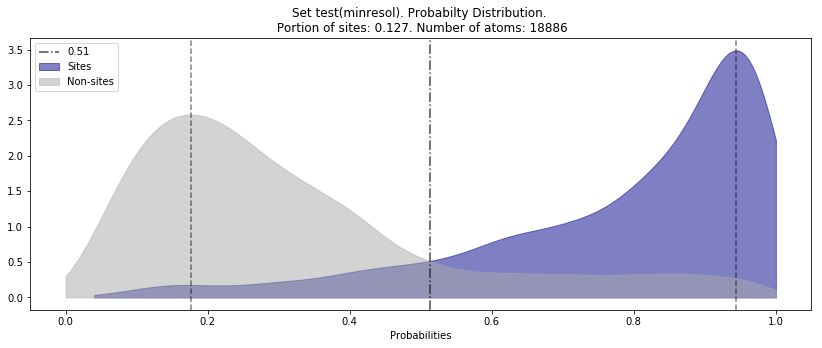

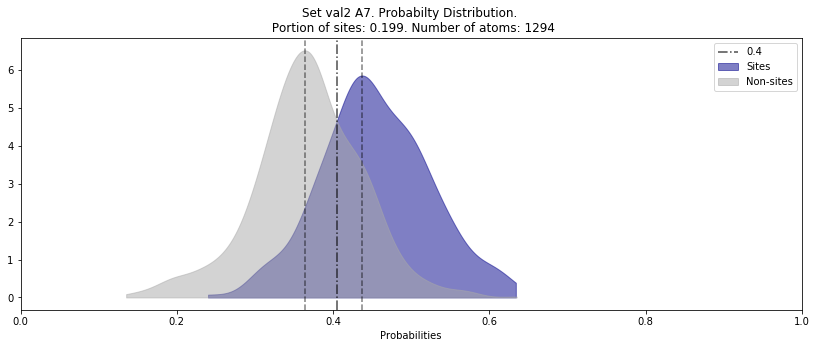

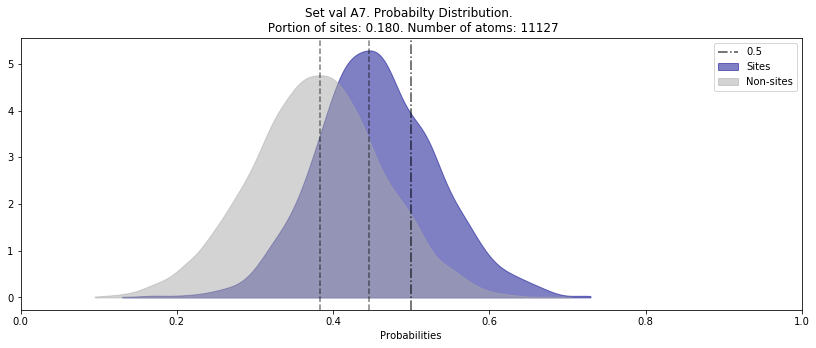

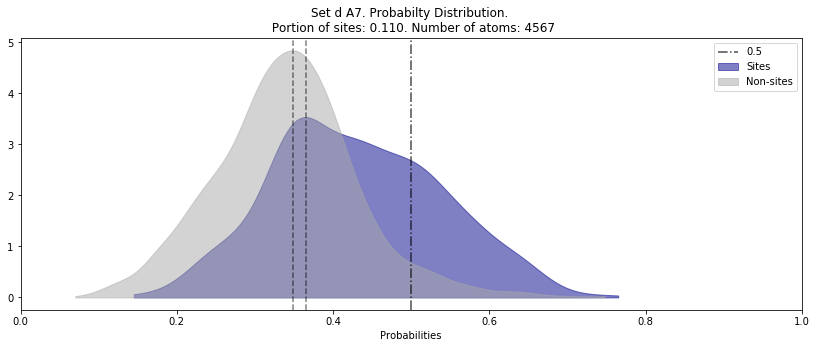

In [9]:
m_val.show_plots({'prob_density':predict_test['plots']['prob_density']})
plt.title('Set test(minresol). Probabilty Distribution. \n Portion of sites: %.3f. Number of atoms: %d'%
          (np.sum(y_test==1)/y_test.shape[0], y_test.shape[0]))
m_val.show_plots({'prob_density':predict_val2['plots']['prob_density']})
plt.title('Set val2 A7. Probabilty Distribution. \n Portion of sites: %.3f. Number of atoms: %d'%
          (np.sum(val2['y']==1)/val2['y'].shape[0], val2['y'].shape[0]))
m_val.show_plots({'prob_density':predict_val['plots']['prob_density']})
plt.title('Set val A7. Probabilty Distribution. \n Portion of sites: %.3f. Number of atoms: %d'%
          (np.sum(val['y']==1)/val['y'].shape[0], val['y'].shape[0]))
m_val.show_plots({'prob_density':predict_d['plots']['prob_density']})
plt.title('Set d A7. Probabilty Distribution. \n Portion of sites: %.3f. Number of atoms: %d'%
          (np.sum(d['y']==1)/d['y'].shape[0], d['y'].shape[0]));

### Save file and send to git

In [28]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" +nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [29]:
path_to_here = os.getcwd()+'\\'
path_to_git = path_to_here.split('New epoch\\')[0]+'New epoch\\coursework_git\\'
path_on_git = path_to_git + path_to_here.split('New epoch\\')[1]
notebook_name = NOTEBOOK_FULL_PATH.split('/')[-1].split('.ipynb')[0]

In [31]:
import subprocess
converted = subprocess.call(["jupyter-nbconvert", '--to', 'html', path_to_here+notebook_name+'.ipynb'], shell=True)

if not os.path.isdir(path_on_git):
    os.mkdir(path_on_git)
if converted==0:
    copied = subprocess.call(["copy", '--to', path_to_here+notebook_name+'.ipynb', path_on_git], shell=True)
    copied += subprocess.call(["copy", '--to', path_to_here+notebook_name+'.html', path_on_git], shell=True)
else:
    raise Exception("The file can't be converted for some reason.")
if copied != 0:
    raise Exception("The file can't be copied for some reason.")

Exception: The file can't be copied for some reason.

In [31]:
%%bash
jupyter-nbconvert --to html path_to_here+notebook_name+'.ipynb'

Couldn't find program: 'bash'
